# Big Data Project
Buongiorno a tutti

In [1]:
# inizializziamo la SparkSession e importiamo le librerie
import findspark

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession \
    .builder \
    .appName("Spark ML example on Credit Card data") \
    .getOrCreate()

21/10/12 17:43:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Lettura del file da hdfs con spark e conteggio delle colonne con valori nulli/NaN

In [2]:
dataSet = spark.read \
    .csv('hdfs://localhost:9099/creditCardProject/creditcard.csv', header = 'True', inferSchema='True')

nullValues = dataSet.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataSet.columns])
nullValues.show()

21/10/12 17:44:05 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Convertiamo in Pandas per una gestione più semplice per poter fare i grafici

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

df = dataSet.toPandas()

Grafico X: Amount --> Y: Class

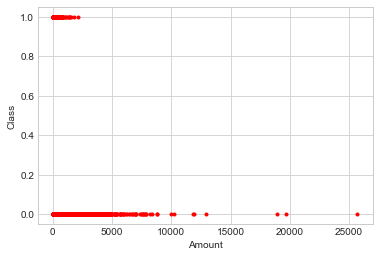

In [4]:
X = df['Amount']
Y = df['Class']

plt.style.use('seaborn-whitegrid')
plt.xlabel("Amount")
plt.ylabel("Class")
plt.scatter(X, Y, marker = ".", color = 'red')
plt.show()

È possibile dedurre che il dataset è sbilanciato e che le transazioni con class = 1 (frodi) hanno un valore di Amount relativamente basso (< 5000).

Grafico: X: Time -- Y:Amount (Rosso frode - Blu non frode)

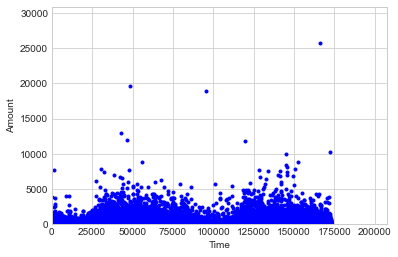

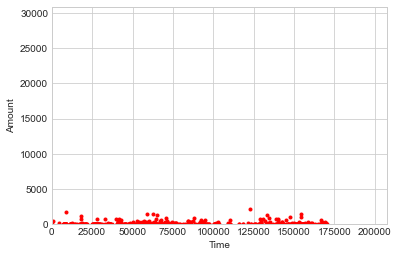

In [5]:
#Grafico non frode
xlim = df['Time'].max() * 1.2
ylim = df['Amount'].max() * 1.2

X = np.where(df['Class']==0, df['Time'], None)
Y = np.where(df['Class']==0, df['Amount'], None)

plt.style.use('seaborn-whitegrid')
plt.xlabel("Time")
plt.ylabel("Amount")
plt.scatter(X, Y, marker = ".", color = "blue")
plt.xlim(0, xlim)
plt.ylim(0, ylim)
plt.show()

#Grafico frode
X = np.where(df['Class']==1, df['Time'], None)
Y = np.where(df['Class']==1, df['Amount'], None)

plt.style.use('seaborn-whitegrid')
plt.xlabel("Time")
plt.ylabel("Amount")
plt.xlim(0, xlim)
plt.ylim(0, ylim)
plt.scatter(X, Y, marker = ".", color = "red")
plt.show()

Secondo me (Davide) è possibile fare discorsi sulla colonna Time, eliminabile a prescindere

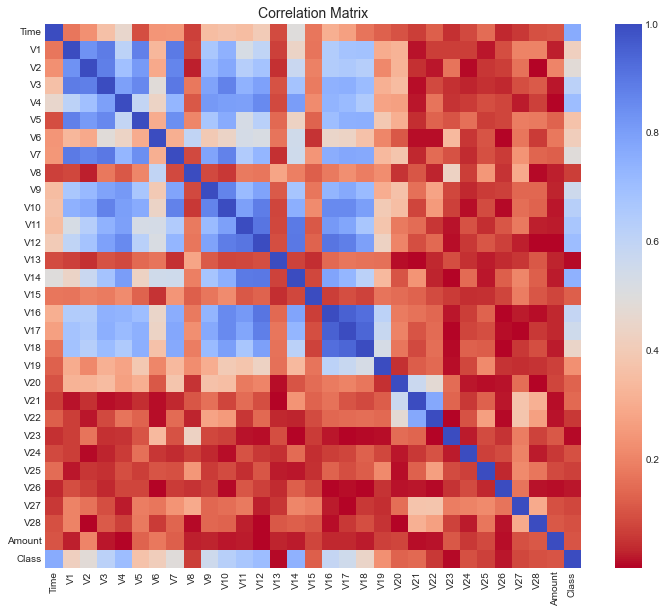

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13        True
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23        True
V24       False
V25       False
V26        True
V27       False
V28       False
Amount    False
Class     False
Name: Class, dtype: bool


In [29]:
import seaborn as sns

# shuffle before creating subsamples

df_fraud = df.loc[df.Class == 1]
df_non_fraud = df.loc[df.Class == 0][1000:1492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

plt.figure(figsize=(12, 10))
corr = dfFifty.corr()
corr = pd.DataFrame.abs(corr)
fig = sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
fig.set_title('Correlation Matrix', fontsize=14)
plt.show()

soglia = 0.05
print(corr["Class"] < soglia)

Calcolo matrice di covarianza per capire quali attributi è possibile eliminare

In [7]:
soglia = 0.05
#print(corr["Class"] < soglia)
#droppiamo V13 e V23 perchè minori della soglia
dfFinal = df.drop(["V13", "V23"], axis = 1)

from sklearn import preprocessing

minMaxScaler = preprocessing.MinMaxScaler()
scaledTime = minMaxScaler.fit_transform(dfFinal[['Time']])
scaledAmount = minMaxScaler.fit_transform(dfFinal[['Amount']])

dfFinal['ScaledTime'] = scaledTime
dfFinal['ScaledAmount'] = scaledAmount

dfFinal = dfFinal.drop(['Time', 'Amount'], axis = 1)

X = dfFinal.iloc[:, dfFinal.columns != 'Class']
y = dfFinal.iloc[:, dfFinal.columns == 'Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 50)

from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

MLPC = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000)
MLPC.fit(X_train, y_train.values.ravel())
y_pred = MLPC.predict(X_test)
# Obtenemos valores de recall
recall_acc = recall_score(y_test,y_pred)
print(recall_acc)
print(MLPC.score(X_test, y_test))

/Applications/anaconda3/envs/mongoDB/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.7142857142857143
0.9993797034280163


In [ ]:
soglia = 0.05
#print(corr["Class"] < soglia)
#droppiamo V13 e V23 perchè minori della soglia
dfFinal = df.drop(["V13", "V23"], axis = 1)

from sklearn import preprocessing

standardScaler = preprocessing.StandardScaler()
scaledTime = standardScaler.fit_transform(X = dfFinal[['Time']])
scaledAmount = standardScaler.fit_transform(X = dfFinal[['Amount']])

dfFinal['ScaledTime'] = scaledTime
dfFinal['ScaledAmount'] = scaledAmount

#ELIMINO V26 PERCHè NELLA MATRICE DI CORRELAZIONE DEL PASSO SUCCESSIVO, V26 è MINORE DI 0.05
dfFinal = dfFinal.drop(['Time', 'Amount', 'V26', 'ScaledTime'], axis = 1)

X = dfFinal.iloc[:, dfFinal.columns != 'Class']
y = dfFinal.iloc[:, dfFinal.columns == 'Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 50)

from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

#hidden_layer_sizes=(200,)
MLPC = MLPClassifier(hidden_layer_sizes=(200, 26), max_iter=10000, activation="tanh", verbose=True)
MLPC.fit(X_train, y_train.values.ravel())
y_pred = MLPC.predict(X_test)
# Obtenemos valores de recall
recall_acc = recall_score(y_test, y_pred)
print(recall_acc)
print(MLPC.score(X_test, y_test))

Divisione del dataset in training set e validation set

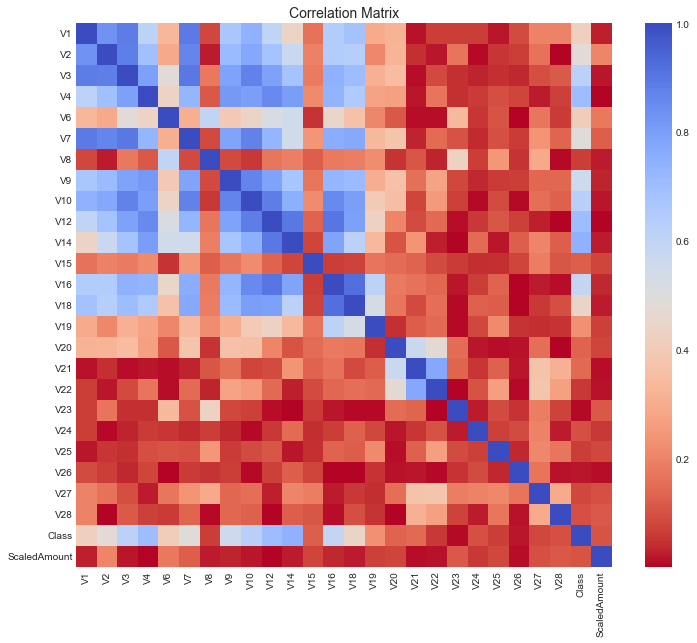

V1              False
V2              False
V3              False
V4              False
V6              False
V7              False
V8              False
V9              False
V10             False
V12             False
V14             False
V15             False
V16             False
V18             False
V19             False
V20             False
V21             False
V22             False
V23              True
V24             False
V25             False
V26              True
V27             False
V28             False
Class           False
ScaledAmount    False
Name: Class, dtype: bool


In [27]:
# shuffle before creating subsamples

df_fraud = dfFinal.loc[dfFinal.Class == 1]
df_non_fraud = dfFinal.loc[dfFinal.Class == 0][1000:1492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

plt.figure(figsize=(12, 10))
corr = dfFifty.corr()
corr = pd.DataFrame.abs(corr)
fig = sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
fig.set_title('Correlation Matrix', fontsize=14)
plt.show()

print(corr["Class"] <= 0.05)

Creazione del modello di predizione

In [ ]:
from skfeature.function.similarity_based import fisher_score
from sklearn.datasets import load_diabetes

db = load_diabetes()
y_train = db.target
X_train = db.data

idx = fisher_score.fisher_score(X_train, y_train) #returns rank directly instead of fisher score. so no need for feature_ranking
print(y_train)

[151.  75. 141. 206. 135.  97. 138.  63. 110. 310. 101.  69. 179. 185.
 118. 171. 166. 144.  97. 168.  68.  49.  68. 245. 184. 202. 137.  85.
 131. 283. 129.  59. 341.  87.  65. 102. 265. 276. 252.  90. 100.  55.
  61.  92. 259.  53. 190. 142.  75. 142. 155. 225.  59. 104. 182. 128.
  52.  37. 170. 170.  61. 144.  52. 128.  71. 163. 150.  97. 160. 178.
  48. 270. 202. 111.  85.  42. 170. 200. 252. 113. 143.  51.  52. 210.
  65. 141.  55. 134.  42. 111.  98. 164.  48.  96.  90. 162. 150. 279.
  92.  83. 128. 102. 302. 198.  95.  53. 134. 144. 232.  81. 104.  59.
 246. 297. 258. 229. 275. 281. 179. 200. 200. 173. 180.  84. 121. 161.
  99. 109. 115. 268. 274. 158. 107.  83. 103. 272.  85. 280. 336. 281.
 118. 317. 235.  60. 174. 259. 178. 128.  96. 126. 288.  88. 292.  71.
 197. 186.  25.  84.  96. 195.  53. 217. 172. 131. 214.  59.  70. 220.
 268. 152.  47.  74. 295. 101. 151. 127. 237. 225.  81. 151. 107.  64.
 138. 185. 265. 101. 137. 143. 141.  79. 292. 178.  91. 116.  86. 122.
  72. 

Valutazione dell'errore del modello ottenuto al passo precedente

In [28]:
from skfeature.function.similarity_based import fisher_score

df_fraud = dfFinal.loc[dfFinal.Class == 1]
df_non_fraud = dfFinal.loc[dfFinal.Class == 0][0:492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

fisherX = np.array(dfFifty.iloc[:, dfFifty.columns != 'Class'])
fisherY = np.array(dfFifty.iloc[:, dfFifty.columns == 'Class'])
fisherY = fisherY.reshape(1, -1)[0]
idx = fisher_score.fisher_score(fisherX, fisherY) #returns rank directly instead of fisher score. so no need for feature_ranking
idx = fisher_score.feature_ranking(idx)
print(idx)

[10  9  3  8  2 12  7  5  1  4 13  0 14 11 15 16 24 23 19 22 20  6 21 17
 18]


In [37]:
#Elimino le feature irrilevanti che hanno un fisher score <= 3 - V13 e V23 eliminate per la matrice di correlazione
dfFinal = df
for i in range(20):
    dfFinal.append(dfFinal.loc[dfFinal.Class == 1])

dfFinal = dfFinal.drop(["V2", "V4", "V8", "V11", "V13", "V23"], axis = 1)

from sklearn import preprocessing

standardScaler = preprocessing.StandardScaler()
scaledTime = standardScaler.fit_transform(X = dfFinal[['Time']])
scaledAmount = standardScaler.fit_transform(X = dfFinal[['Amount']])

dfFinal['ScaledTime'] = scaledTime
dfFinal['ScaledAmount'] = scaledAmount

dfFinal = dfFinal.drop(['Time', 'Amount', 'ScaledTime'], axis = 1)

X = dfFinal.iloc[:, dfFinal.columns != 'Class']
y = dfFinal.iloc[:, dfFinal.columns == 'Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 50)

from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

#hidden_layer_sizes=(200,)
MLPC = MLPClassifier(hidden_layer_sizes=(200,6), max_iter=10000, verbose=True)
MLPC.fit(X_train, y_train.values.ravel())
y_pred = MLPC.predict(X_test)
# Obtenemos valores de recall
recall_acc = recall_score(y_test, y_pred)
print(recall_acc)
print(MLPC.score(X_test, y_test))

5
11
13
17

Iteration 1, loss = 0.00952366
Iteration 2, loss = 0.00289922
Iteration 3, loss = 0.00267006
Iteration 4, loss = 0.00255700
Iteration 5, loss = 0.00232369
Iteration 6, loss = 0.00223396
Iteration 7, loss = 0.00218862
Iteration 8, loss = 0.00204734
Iteration 9, loss = 0.00200217
Iteration 10, loss = 0.00188160
Iteration 11, loss = 0.00180152
Iteration 12, loss = 0.00170790
Iteration 13, loss = 0.00160190
Iteration 14, loss = 0.00166230
Iteration 15, loss = 0.00144891
Iteration 16, loss = 0.00143395
Iteration 17, loss = 0.00142623
Iteration 18, loss = 0.00133092
Iteration 19, loss = 0.00124961
Iteration 20, loss = 0.00128679
Iteration 21, loss = 0.00120102
Iteration 22, loss = 0.00114639
Iteration 23, loss = 0.00116490
Iteration 24, loss = 0.00105378
Iteration 25, loss = 0.00093474
Iteration 26, loss = 0.00099113
Iteration 27, loss = 0.00101228
Iteration 28, loss = 0.00096277
Iteration 29, loss = 0.00087162
Iteration 30, loss = 0.00091279
Iteration 31, loss = 0.00099882
Iteration 32, los

17